In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import warnings


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D, Bidirectional


warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Musical_instruments_reviews.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


In [3]:
#Verificando valores ausentes
df.isnull().sum()

print((df.isnull().sum() / len(df)) * 100)


reviewerID        0.000000
asin              0.000000
reviewerName      0.263132
helpful           0.000000
reviewText        0.068219
overall           0.000000
summary           0.000000
unixReviewTime    0.000000
reviewTime        0.000000
dtype: float64


Análise dos Valores Ausentes
    - reviewerName: 26.3% dos dados estão ausentes. Isso é uma quantidade significativa.
    - reviewText: 6.8% dos dados estão ausentes. Como essa coluna contém o texto das avaliações, é aconselhável remover essas entradas, pois são essenciais para sua análise.

In [4]:
#Tratando valores ausentes
df.dropna(subset=['reviewText'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['reviewerName'].fillna('Unknown', inplace=True)

print(df.isnull().sum())


reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64


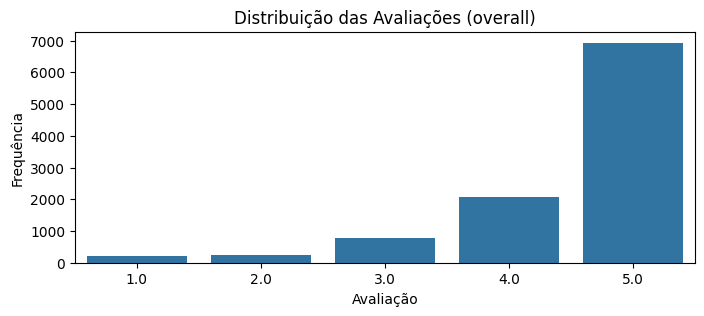

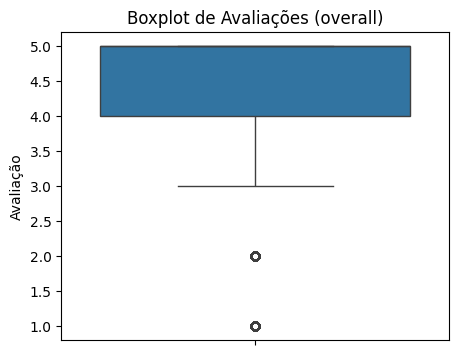

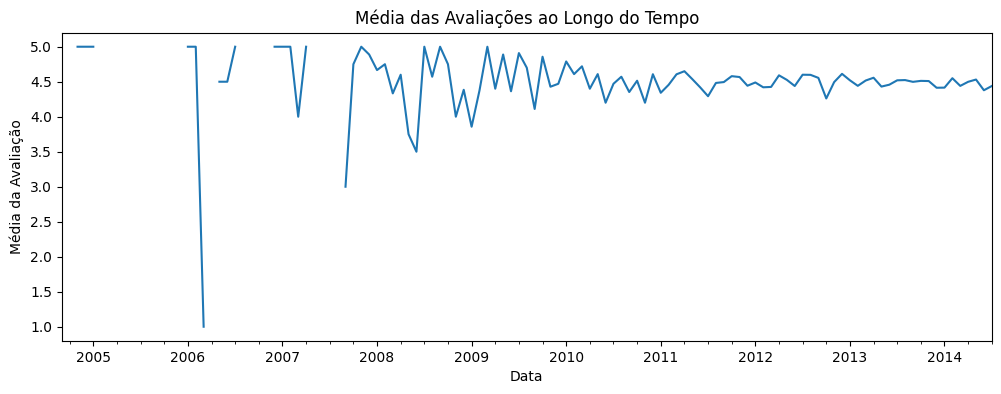

In [5]:
#Distribuição das Avaliações (overall)
plt.figure(figsize=(8, 3))
sns.countplot(data=df, x='overall')
plt.title('Distribuição das Avaliações (overall)')
plt.xlabel('Avaliação')
plt.ylabel('Frequência')
plt.show()

plt.figure(figsize=(5, 4))
sns.boxplot(data=df, y='overall')
plt.title('Boxplot de Avaliações (overall)')
plt.ylabel('Avaliação')
plt.show()


# Plotar a distribuição das avaliações ao longo do tempo
df['reviewDate'] = pd.to_datetime(df['unixReviewTime'], unit='s')
plt.figure(figsize=(12, 4))
df.set_index('reviewDate').resample('M')['overall'].mean().plot()
plt.title('Média das Avaliações ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Média da Avaliação')
plt.show()


In [6]:
df["Text"]  = df["summary"] + ". " + df["reviewText"] 

df.drop(["summary", "reviewText", "asin", "reviewerName", "reviewerID", "helpful", "unixReviewTime", "reviewTime"], axis=1, inplace=True)
df.head()

,overall,reviewDate,Text
0,5.0,2014-02-28,"good. Not much to write about here, but it doe..."
1,5.0,2013-03-16,Jake. The product does exactly as it should an...
2,5.0,2013-08-28,It Does The Job Well. The primary job of this ...
3,5.0,2014-02-14,GOOD WINDSCREEN FOR THE MONEY. Nice windscreen...
4,5.0,2014-02-21,No more pops when I record my vocals.. This po...


In [7]:
#Limpeza textual
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michelle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import string
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

In [9]:
df['cleaned_review'] = df['Text'].apply(clean_text)
df.head()

,overall,reviewDate,Text,cleaned_review
0,5.0,2014-02-28,"good. Not much to write about here, but it doe...",good much write exactly supposed filters pop s...
1,5.0,2013-03-16,Jake. The product does exactly as it should an...,jake product exactly quite affordablei realize...
2,5.0,2013-08-28,It Does The Job Well. The primary job of this ...,job well primary job device block breath would...
3,5.0,2014-02-14,GOOD WINDSCREEN FOR THE MONEY. Nice windscreen...,good windscreen money nice windscreen protects...
4,5.0,2014-02-21,No more pops when I record my vocals.. This po...,pops record vocals pop filter great looks perf...


In [10]:
def classify_rating(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating == 3.0:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['overall'].apply(classify_rating)

df.head()

,overall,reviewDate,Text,cleaned_review,sentiment
0,5.0,2014-02-28,"good. Not much to write about here, but it doe...",good much write exactly supposed filters pop s...,positive
1,5.0,2013-03-16,Jake. The product does exactly as it should an...,jake product exactly quite affordablei realize...,positive
2,5.0,2013-08-28,It Does The Job Well. The primary job of this ...,job well primary job device block breath would...,positive
3,5.0,2014-02-14,GOOD WINDSCREEN FOR THE MONEY. Nice windscreen...,good windscreen money nice windscreen protects...,positive
4,5.0,2014-02-21,No more pops when I record my vocals.. This po...,pops record vocals pop filter great looks perf...,positive


In [11]:
X = df["cleaned_review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = TfidfVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [12]:
#Lista de Modelos
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC()
} 
results = {}


In [13]:
def fit_model():
    for model_name, model in models.items():
        model.fit(X_train_vectorized, y_train)
        y_pred = model.predict(X_test_vectorized)
        accuracy = accuracy_score(y_test, y_pred)
        results[model_name] = {
            "accuracy": accuracy,
            "classification_report": classification_report(y_test, y_pred, output_dict=True)
        }

def get_model_results():
    for model_name, result in results.items():
        print(f"{model_name}:")
        print(f"Accuracy: {result['accuracy']:.4f}")
        print("Classification Report:")
        print(result['classification_report'])
        print("\n")

In [14]:
fit_model()

get_model_results()

Logistic Regression:
Accuracy: 0.8874
Classification Report:
{'negative': {'precision': 0.8333333333333334, 'recall': 0.04672897196261682, 'f1-score': 0.08849557522123894, 'support': 107.0}, 'neutral': {'precision': 0.5, 'recall': 0.07518796992481203, 'f1-score': 0.13071895424836602, 'support': 133.0}, 'positive': {'precision': 0.891358024691358, 'recall': 0.9966869133075649, 'f1-score': 0.9410844629822732, 'support': 1811.0}, 'accuracy': 0.8873720136518771, 'macro avg': {'precision': 0.7415637860082306, 'recall': 0.3728679517316646, 'f1-score': 0.38676633081729267, 'support': 2051.0}, 'weighted avg': {'precision': 0.8629527300744594, 'recall': 0.8873720136518771, 'f1-score': 0.8440558800217466, 'support': 2051.0}}


Decision Tree:
Accuracy: 0.8376
Classification Report:
{'negative': {'precision': 0.32098765432098764, 'recall': 0.24299065420560748, 'f1-score': 0.2765957446808511, 'support': 107.0}, 'neutral': {'precision': 0.14925373134328357, 'recall': 0.15037593984962405, 'f1-score':

# Análise do Modelo
Melhor Acurácia:

A Regressão Logística teve a melhor acurácia (0.8879) entre os modelos testados.

Desempenho em Classes:

    - Classe Positiva: A maioria dos modelos apresenta bom desempenho nessa classe, especialmente a Regressão Logística e o Gradient Boosting, com F1-scores acima de 0.94.
    - Classe Neutra: Todos os modelos têm um desempenho fraco nesta classe, especialmente o SVM, que teve um F1-score de 0.0145.
    - Classe Negativa: O desempenho é consistentemente baixo para todos os modelos, especialmente o SVM, que não conseguiu prever essa classe.

In [15]:
# Removendo classe neutral
def classify_rating(rating):
    if rating >= 4.0:
        return 1
    else:
        return 0

df['sentiment'] = df['overall'].apply(classify_rating)

In [16]:
X = df["cleaned_review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = TfidfVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [17]:
results = {}
fit_model()

get_model_results()

Logistic Regression:
Accuracy: 0.8918
Classification Report:
{'0': {'precision': 0.8461538461538461, 'recall': 0.09166666666666666, 'f1-score': 0.16541353383458646, 'support': 240.0}, '1': {'precision': 0.8923456790123456, 'recall': 0.9977912755383765, 'f1-score': 0.9421272158498436, 'support': 1811.0}, 'accuracy': 0.8917601170160897, 'macro avg': {'precision': 0.8692497625830959, 'recall': 0.5447289711025216, 'f1-score': 0.553770374842215, 'support': 2051.0}, 'weighted avg': {'precision': 0.8869404913545983, 'recall': 0.8917601170160897, 'f1-score': 0.8512392179543479, 'support': 2051.0}}


Decision Tree:
Accuracy: 0.8493
Classification Report:
{'0': {'precision': 0.35802469135802467, 'recall': 0.3625, 'f1-score': 0.36024844720496896, 'support': 240.0}, '1': {'precision': 0.9153761061946902, 'recall': 0.913859745996687, 'f1-score': 0.914617297596021, 'support': 1811.0}, 'accuracy': 0.8493417844953681, 'macro avg': {'precision': 0.6367003987763574, 'recall': 0.6381798729983434, 'f1-sco

In [18]:
# Tokenização
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding das sequências
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [19]:
# Dividir os dados em características (X) e rótulos (y)
X = df['cleaned_review']
y = df['sentiment']

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Treinamento: {len(X_train)}, Teste: {len(X_test)}')


Treinamento: 8203, Teste: 2051


In [20]:
# Criar o modelo simples
simple_nn = Sequential()
simple_nn.add(Dense(64, activation='relu', input_shape=(max_length,)))
simple_nn.add(Dense(32, activation='relu'))
simple_nn.add(Dense(1, activation='sigmoid'))  # Saída binária

# Compilar o modelo
simple_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumo do modelo
simple_nn.summary()

# Treinar o modelo
history_simple = simple_nn.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7301 - loss: 77.8265 - val_accuracy: 0.7672 - val_loss: 18.9013
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8033 - loss: 11.5702 - val_accuracy: 0.8202 - val_loss: 4.1633
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8425 - loss: 2.1662 - val_accuracy: 0.8568 - val_loss: 1.3645
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8675 - loss: 0.8235 - val_accuracy: 0.8641 - val_loss: 0.9040
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8806 - loss: 0.5398 - val_accuracy: 0.8672 - val_loss: 0.7501


In [21]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# Definindo o modelo LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 100, input_length=max_length))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))  # Para 2 classes: positiva e negativa

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
model_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))


Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.8613 - loss: 0.4498 - val_accuracy: 0.8830 - val_loss: 0.3405
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.8787 - loss: 0.3053 - val_accuracy: 0.8830 - val_loss: 0.3064
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.9274 - loss: 0.2007 - val_accuracy: 0.8869 - val_loss: 0.3034
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.9436 - loss: 0.1489 - val_accuracy: 0.8762 - val_loss: 0.3377
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9618 - loss: 0.1160 - val_accuracy: 0.8669 - val_loss: 0.3748


In [38]:
# Criar o modelo CNN
cnn_model = Sequential()
cnn_model.add(Embedding(max_words, 128, input_length=max_length))
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(SpatialDropout1D(0.2))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))  # Saída binária

# Compilar o modelo
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumo do modelo
cnn_model.summary()

# Treinar o modelo
history_cnn = cnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8573 - loss: 0.4231 - val_accuracy: 0.8757 - val_loss: 0.2973
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9074 - loss: 0.2238 - val_accuracy: 0.8958 - val_loss: 0.2707
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9604 - loss: 0.1085 - val_accuracy: 0.8915 - val_loss: 0.3192
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9888 - loss: 0.0351 - val_accuracy: 0.8927 - val_loss: 0.3868
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9974 - loss: 0.0144 - val_accuracy: 0.8879 - val_loss: 0.5231


In [23]:
# Criar o modelo LSTM
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 128, input_length=max_length))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))  # Saída binária

# Compilar o modelo
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumo do modelo
lstm_model.summary()

# Treinar o modelo
history_lstm = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.8711 - loss: 0.4213 - val_accuracy: 0.8726 - val_loss: 0.3379
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.8858 - loss: 0.2733 - val_accuracy: 0.8818 - val_loss: 0.3195
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9386 - loss: 0.1767 - val_accuracy: 0.8793 - val_loss: 0.3394
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9529 - loss: 0.1335 - val_accuracy: 0.8763 - val_loss: 0.4071
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.9772 - loss: 0.0789 - val_accuracy: 0.8720 - val_loss: 0.4848


In [24]:
# Criar o modelo Bidirectional LSTM
bidir_lstm_model = Sequential()
bidir_lstm_model.add(Embedding(max_words, 128, input_length=max_length))
bidir_lstm_model.add(SpatialDropout1D(0.2))
bidir_lstm_model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
bidir_lstm_model.add(Dense(1, activation='sigmoid'))  # Saída binária

# Compilar o modelo
bidir_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumo do modelo
bidir_lstm_model.summary()

# Treinar o modelo
history_bidir_lstm = bidir_lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.8600 - loss: 0.3992 - val_accuracy: 0.8726 - val_loss: 0.3309
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.8982 - loss: 0.2543 - val_accuracy: 0.8897 - val_loss: 0.3083
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.9386 - loss: 0.1697 - val_accuracy: 0.8800 - val_loss: 0.3486
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9639 - loss: 0.1111 - val_accuracy: 0.8800 - val_loss: 0.3854
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.9753 - loss: 0.0762 - val_accuracy: 0.8720 - val_loss: 0.4393


In [25]:
# Função para avaliar o modelo
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Avaliar cada modelo
evaluate_model(simple_nn, X_test_pad, y_test, "Simple Neural Network")
evaluate_model(cnn_model, X_test_pad, y_test, "Convolutional Neural Network")
evaluate_model(lstm_model, X_test_pad, y_test, "Recurrent Neural Network (LSTM)")
evaluate_model(bidir_lstm_model, X_test_pad, y_test, "Bidirectional LSTM")


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Simple Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.02      0.03       240
           1       0.88      0.99      0.93      1811

    accuracy                           0.87      2051
   macro avg       0.52      0.50      0.48      2051
weighted avg       0.80      0.87      0.83      2051

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Convolutional Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.38      0.46       240
           1       0.92      0.96      0.94      1811

    accuracy                           0.90      2051
   macro avg       0.75      0.67      0.70      2051
weighted avg       0.88      0.90      0.89      2051

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Recurrent Neural Network (LSTM) Classification Report:
              precision    recall  f1-score   support

           0       0.

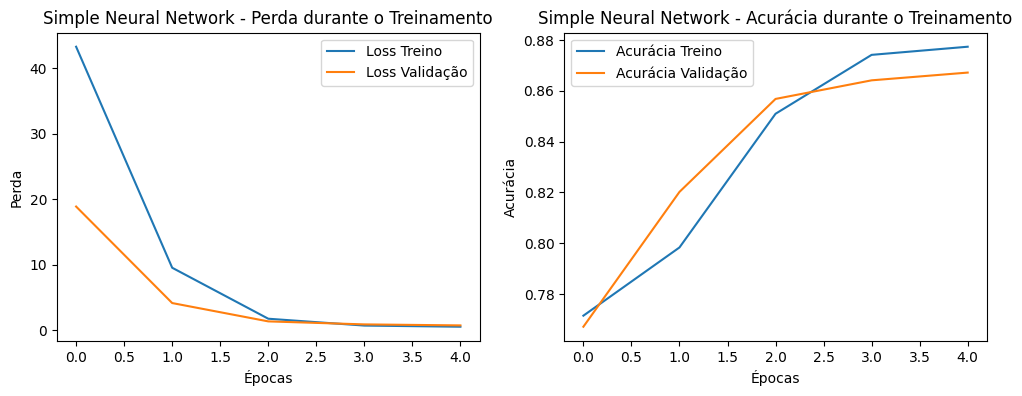

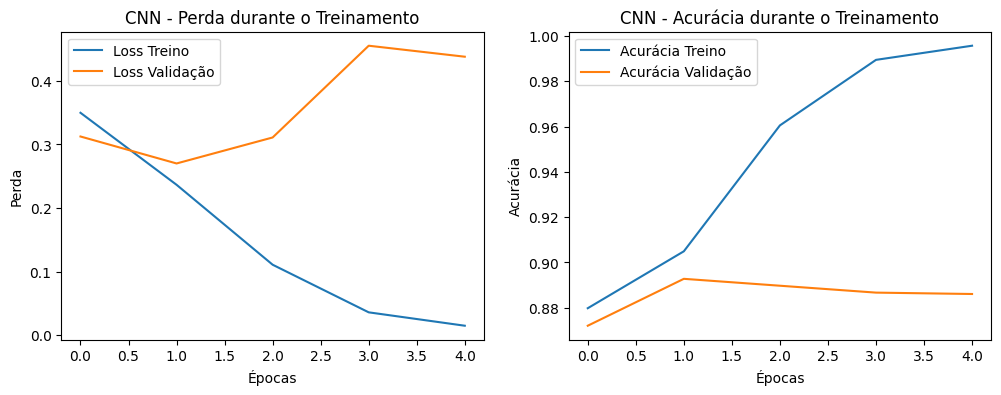

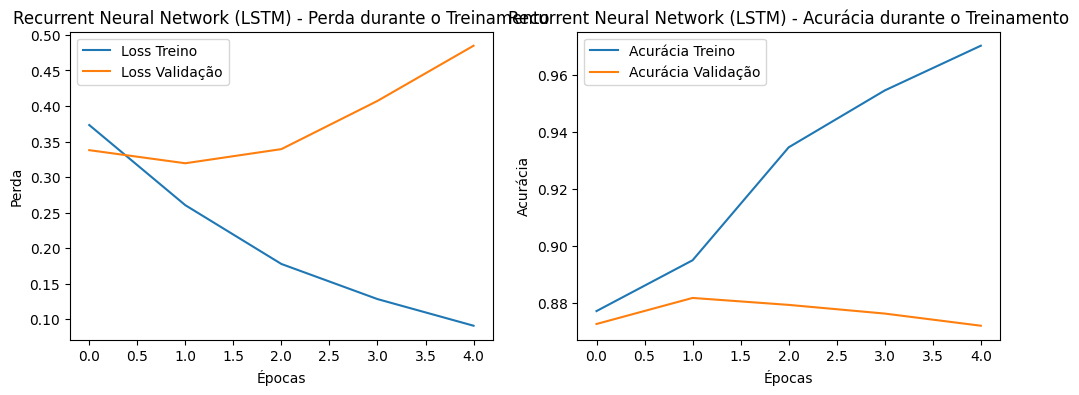

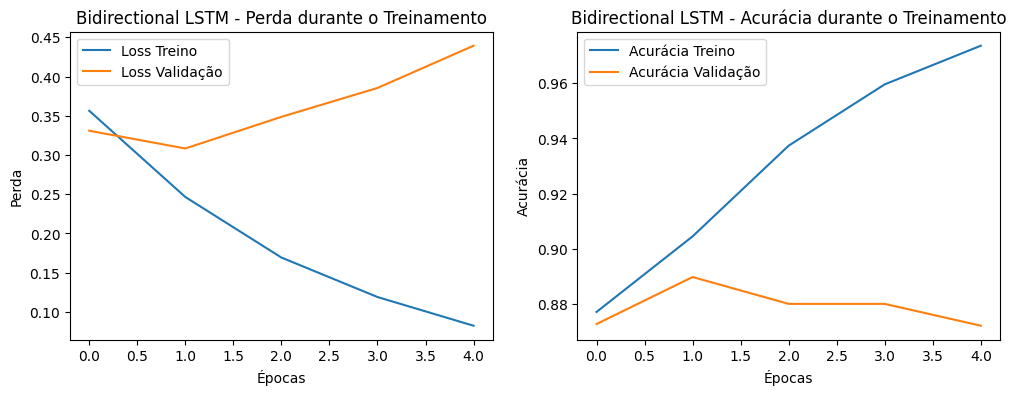

In [26]:
def plot_history(history, model_name):
    plt.figure(figsize=(12,4))
    
    # Plotar perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss Treino')
    plt.plot(history.history['val_loss'], label='Loss Validação')
    plt.title(f'{model_name} - Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    
    # Plotar acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title(f'{model_name} - Acurácia durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    plt.show()

# Plotar histórico de cada modelo
plot_history(history_simple, "Simple Neural Network")
plot_history(history_cnn, "CNN")
plot_history(history_lstm, "Recurrent Neural Network (LSTM)")
plot_history(history_bidir_lstm, "Bidirectional LSTM")


In [43]:
y_pred = cnn_model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


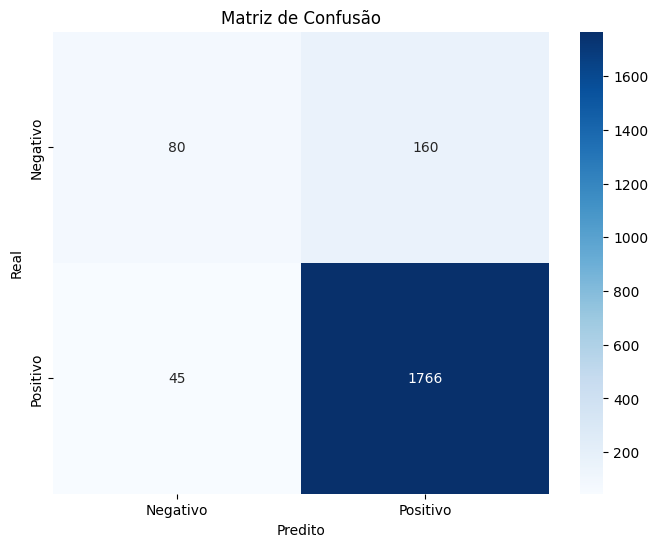

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

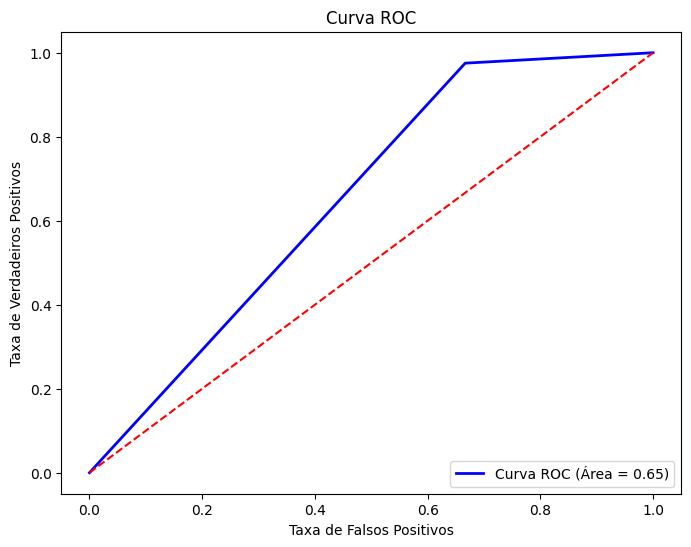

In [42]:
from sklearn.metrics import roc_curve, auc

# Calcule a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (Área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.show()


In [50]:
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier

# Execute validação cruzada
model = KerasClassifier(model=cnn_model, epochs=10, batch_size=32)

cv_scores = cross_val_score(model, X_train_pad, y_train, cv=3)

print(f'Média da Acurácia: {cv_scores.mean():.2f}')
print(f'Desvio Padrão da Acurácia: {cv_scores.std():.2f}')


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9619 - loss: 0.1369
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9949 - loss: 0.0253
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9996 - loss: 0.0058
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9986 - loss: 0.0049
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9997 - loss: 0.0018
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9992 - loss: 0.0046
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 1.0000 - loss: 9.6167e-04
Epoch 9/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9998 - loss: 0.0013
Epoch 10/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 1.0000 - loss: 4.5820e-04
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9615 - loss: 0.

In [53]:
cnn_model.save('cnn_model.h5')